In [2]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
import tabulate
import os
import joblib
import warnings

In [3]:
def Display_all_columns_nrow(df, n): # Example 8 = Top 4 & Bottom 4 Rows with all column view on scroll
    with pd.option_context("display.max_rows", n, "display.max_columns", df.shape[1]): 
        display(df)

In [4]:
df = pd.read_hdf('data/df_transactions_continue.h5')
Display_all_columns_nrow(df, 6)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,False,False,False
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,True,False,False
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786360,732852505,732852505,50000,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,01,rideshare,2025-08-01,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1233.85,False,False,False
786361,732852505,732852505,50000,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,99,online_retail,2022-07-01,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1283.28,False,False,False
786362,732852505,732852505,50000,48666.83,2016-12-30 20:10:29,72.18,Uber,US,US,05,01,rideshare,2024-05-01,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1333.17,False,False,False


In [5]:
df.dtypes

accountNumber                        int64
customerId                           int64
creditLimit                          int64
availableMoney                     float64
transactionDateTime         datetime64[ns]
transactionAmount                  float64
merchantName                        object
acqCountry                          object
merchantCountryCode                 object
posEntryMode                        object
posConditionCode                    object
merchantCategoryCode                object
currentExpDate              datetime64[ns]
accountOpenDate             datetime64[ns]
dateOfLastAddressChange     datetime64[ns]
cardCVV                              int64
enteredCVV                           int64
cardLast4Digits                      int64
transactionType                     object
currentBalance                     float64
cardPresent                           bool
expirationDateKeyInMatch              bool
isFraud                               bool
dtype: obje

In [6]:
df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

# Data Wrangling: Reversed Transactions

A reversed transaction, in the context of financial or transactional systems, refers to the act of nullifying or undoing a previously completed transaction. This can involve the cancellation of a financial entry, such as a purchase or payment, and its associated effects, thereby effectively reverting the affected accounts or records to their pre-transaction state. Reversed transactions are often utilized to rectify errors, address disputes, or accommodate customer requests for refunds or corrections. The reversal process typically involves generating an entry that offsets the original transaction's impact, ensuring that the overall financial or operational integrity of the system is maintained.

The code uses a set-based approach to efficiently identify transactions that are reversed by comparing 'PURCHASE' and 'REVERSAL' transactions, and then presents these transactions in a separate DataFrame for further analysis. Set Intersection is used to find the intersection between the Purchase and reversal these will make sure that we take only those elements which have same selected_columns. (i.e. P ∩ R)

In [7]:
# These columns I am not using while finding reversed tranasction
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]

acqCountry             4562
posEntryMode           4054
merchantCountryCode     724
transactionType         698
posConditionCode        409
dtype: int64

In [8]:
selected_columns = ['accountNumber', 'customerId', 'creditLimit', 'transactionAmount', 'merchantName','cardLast4Digits',
'accountOpenDate', 'cardCVV', 'enteredCVV','expirationDateKeyInMatch', 'isFraud']

# Extracting only necessary columns
df_PURCHASE_subset = df[selected_columns][df['transactionType'] == 'PURCHASE']
df_REVERSAL_subset = df[selected_columns][df['transactionType'] == 'REVERSAL']

# Creating sets of tuples for efficient comparison
purchased_set = set(map(tuple, df_PURCHASE_subset.values))
reversal_set = set(map(tuple, df_REVERSAL_subset.values))

# Finding the common transactions (reversed transactions)
reversed_transactions = purchased_set.intersection(reversal_set)

# Converting back to a dataframe
reversed_transactions_df = pd.DataFrame(list(reversed_transactions), columns=selected_columns)
reversed_transactions_df

,accountNumber,customerId,creditLimit,transactionAmount,merchantName,cardLast4Digits,accountOpenDate,cardCVV,enteredCVV,expirationDateKeyInMatch,isFraud
0,601264054,601264054,7500,465.01,AMC #606218,8907,2014-07-21,769,769,False,False
1,384866198,384866198,7500,237.63,In-N-Out #569471,3754,2013-03-26,285,285,False,False
2,473950648,473950648,5000,10.16,EZ Putt Putt #551896,1240,2015-10-14,148,148,False,False
3,607631849,607631849,2500,68.84,Universe Massage #777394,7618,2015-06-21,804,804,False,False
4,934308262,934308262,500,433.52,walmart.com,4564,2009-06-22,171,171,False,False
...,...,...,...,...,...,...,...,...,...,...,...
17763,873724196,873724196,10000,8.27,Dinosaur Sandwitch Bar #960325,8792,2015-09-29,472,472,False,False
17764,782081187,782081187,15000,59.41,Mobile eCards,7256,2014-01-15,363,363,False,False
17765,386364078,386364078,5000,289.71,Regal Cinemas #276341,7359,2012-05-05,375,375,False,False
17766,500505733,500505733,1000,302.17,cheapfast.com,6364,2015-09-21,609,609,False,False


Insights: As observed, the newly generated dataframe resulting from the intersection operation contains 17,768 rows. This intersection was performed exclusively on the specified columns. Consequently, the resultant df_REVERSAL_subset and df_PURCHASE_subset dataframes exclusively include rows where all selected columns exhibit identical data. It's important to note that Reversal entries whose data in these selected columns does not match are excluded, given that they are not associated with the preceding PURCHASE transactions.

Optional Way: Instead of set conversion this can also be solved with similar output using inner join.

Side note: Initially, I held the assumption that a REVERSAL transaction immediately follows a PURCHASE in the event of an issue. However, this is not universally true, as a REVERSAL can occur after a certain time interval, potentially even a day, and there might be different transactions transpiring in between. Acknowledging this, I adjusted my approach for identifying reversal transactions, opting for the intersection methodology described above.

**Just to verify the results: I am checking weather for particular record in reversed_transactions_df there exist two rows in df one for PURCHASE, one for REVERSAL.

In [9]:
reversed_transactions_df.sort_values(by=['accountNumber', 'customerId', 'transactionAmount'], inplace=True)
Display_all_columns_nrow(reversed_transactions_df,6)

,accountNumber,customerId,creditLimit,transactionAmount,merchantName,cardLast4Digits,accountOpenDate,cardCVV,enteredCVV,expirationDateKeyInMatch,isFraud
2229,100088067,100088067,50000,22.32,AMC #79863,4615,2014-01-09,546,546,False,False
570,100328049,100328049,5000,43.74,Lyft,2941,2014-01-07,206,206,False,False
16287,100328049,100328049,5000,284.97,McDonalds #423357,2941,2014-01-07,206,206,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4460,999283629,999283629,2500,150.58,Franks Sandwitch Bar,3016,2015-11-08,489,489,False,False
14,999283629,999283629,2500,247.40,Delta Airlines,4157,2015-11-08,919,919,False,False
7085,999283629,999283629,2500,407.23,apple.com,3016,2015-11-08,489,487,False,False


In [10]:
df[(df['accountNumber']==100088067)&(df['creditLimit']==50000)&(df['transactionAmount']==22.32)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
541963,100088067,100088067,50000,49834.20,2016-11-20 07:57:05,22.32,AMC #79863,US,US,09,...,2014-01-09,2014-01-09,546,546,4615,PURCHASE,165.80,True,False,False
541964,100088067,100088067,50000,49811.88,2016-11-20 08:00:04,22.32,AMC #79863,US,US,09,...,2014-01-09,2014-01-09,546,546,4615,REVERSAL,188.12,True,False,False


In [11]:
df[(df['accountNumber']==100328049)&(df['creditLimit']==5000)&(df['transactionAmount']==43.74)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
87919,100328049,100328049,5000,4648.84,2016-01-15 20:34:35,43.74,Lyft,US,US,09,...,2014-01-07,2014-01-07,206,206,2941,PURCHASE,351.16,False,False,False
87920,100328049,100328049,5000,4605.10,2016-01-15 20:36:18,43.74,Lyft,US,US,09,...,2014-01-07,2014-01-07,206,206,2941,REVERSAL,394.90,False,False,False


In [19]:
df[(df['accountNumber']==999283629)&(df['creditLimit']==2500)&(df['transactionAmount']==407.23)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
670084,999283629,999283629,2500,1775.48,2016-09-15 06:35:31,407.23,apple.com,US,US,05,...,2015-11-08,2016-03-09,489,487,3016,PURCHASE,724.52,False,False,False
670091,999283629,999283629,2500,2500.00,2016-10-03 11:08:21,407.23,apple.com,US,US,05,...,2015-11-08,2016-03-09,489,487,3016,REVERSAL,0.00,False,False,False


In [12]:
print(f"Total Reversed Transactions: {reversed_transactions_df.shape[0]}")
print(f"Total Reversed Transactions : ${round(reversed_transactions_df['transactionAmount'].sum(),2)}")

Total Reversed Transactions: 17768
Total Reversed Transactions : $2666966.41


Below I am identifying total number of Transaction with transactionType as REVERSAL but not linked with previous PURCHASE

In [13]:
not_linked_with_purchased = len(df[df['transactionType'] == 'REVERSAL']) - reversed_transactions_df.shape[0]
print("Number of REVERSAL transactions not linked with previous PURCHASE:", not_linked_with_purchased)

not_linked_reversal_sum = df[df['transactionType'] == 'REVERSAL']['transactionAmount'].sum() - reversed_transactions_df['transactionAmount'].sum()
print(f"REVERSAL transactions Amounts not linked with PURCHASE: ${round(not_linked_reversal_sum, 3)}")

Number of REVERSAL transactions not linked with previous PURCHASE: 2535
REVERSAL transactions Amounts not linked with PURCHASE: $154826.09


# Data Wrangling: Multi-Swipe Transactions

A multi-swipe transaction pertains to a scenario in which a payment or transaction is carried out through multiple instances of card swiping or electronic payment attempts within a single transaction event. This can occur when a customer or cardholder repeatedly swipes their payment card, such as a credit or debit card, to complete a single purchase or transaction. Multi-swipe transactions might arise due to technical issues, communication failures, or user errors, leading to the need for multiple attempts to successfully process the transaction. It's worth noting that the multiple swipes are meant to contribute to a single, cohesive transaction, even though they involve repeated card interactions.

Note: 
1. Over Here I am assuming the the time window for multi swipe transaction is maximum of 5 minutes it can vary based on the usecase or based on the domain. Also since there are different merchants and service provider there may be delay in the multi swipe transaction. (This is the assumption which need to be clarified before implementing.)
2. In the context of my analysis, I focused on examining a dataframe containing transaction records. The main objective was to pinpoint potential instances of duplicated 'PURCHASE' transactions within the dataset. I initiated this process by filtering the dataframe to exclusively include rows with the 'transactionType' labeled as 'PURCHASE'. 
3. Subsequently, I identified potential duplicates by evaluating shared attributes such as 'accountNumber', 'customerId', 'transactionAmount', 'merchantName', and 'cardLast4Digits'. 
4. The next step involved calculating the time difference between successive transactions that fell under the same 'accountNumber', 'customerId', and 'merchantName' group. This calculation was based on the 'transactionDateTime' attribute. 
5. To enhance clarity, I extracted and displayed pertinent columns associated with duplicated transactions and their respective time differences. Moreover, I refined the results by selecting transactions exhibiting time differences of less than 5 minutes, indicative of possible instances of multiple swipe scenarios. 
6. As part of the investigation, I constructed a test dataset that encompassed transactions meeting the time difference threshold, as well as those with no discernible time difference. These actions collectively contributed to the comprehensive analysis of 'PURCHASE' transaction duplicates and potential occurrences of multiple swipes within the dataset, as outlined in my report.








In [14]:
df_purchase = df[df.transactionType == 'PURCHASE']
df_duplicated_purchase = df_purchase[df_purchase.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName','cardLast4Digits'],keep=False)]
df_duplicated_purchase.sort_values(['accountNumber', 'customerId', 'merchantName', 'transactionDateTime'])
df_duplicated_purchase.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
11,830329091,830329091,5000,5000.00,2016-12-07 16:34:04,40.75,GreenCook,US,US,09,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,False,False,False
12,830329091,830329091,5000,4959.25,2016-12-14 10:00:35,40.75,GreenCook,US,US,09,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,40.75,False,False,False
13,830329091,830329091,5000,4918.50,2016-12-20 18:38:23,40.75,GreenCook,US,US,09,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,81.50,False,False,False


In [15]:
warnings.filterwarnings("ignore")
df_duplicated_purchase['timeDifference'] = df_duplicated_purchase.groupby(['accountNumber', 'customerId', 'merchantName'])['transactionDateTime'].diff()
df_duplicated_purchase[['accountNumber', 'customerId', 'transactionAmount', 'merchantName','cardLast4Digits','transactionDateTime','timeDifference']]

,accountNumber,customerId,transactionAmount,merchantName,cardLast4Digits,transactionDateTime,timeDifference
2,737265056,737265056,7.47,Play Store,767,2016-11-08 09:18:39,NaT
3,737265056,737265056,7.47,Play Store,767,2016-12-10 02:14:50,31 days 16:56:11
11,830329091,830329091,40.75,GreenCook,3143,2016-12-07 16:34:04,NaT
12,830329091,830329091,40.75,GreenCook,3143,2016-12-14 10:00:35,6 days 17:26:31
13,830329091,830329091,40.75,GreenCook,3143,2016-12-20 18:38:23,6 days 08:37:48
...,...,...,...,...,...,...,...
786346,732852505,732852505,51.48,Sunoco Gas #380975,3783,2016-11-22 19:30:16,13 days 05:31:29
786348,732852505,732852505,18.89,hulu.com,3388,2016-11-25 13:39:10,30 days 02:26:49
786352,732852505,732852505,51.48,Sunoco Gas #380975,3783,2016-12-07 14:05:14,14 days 18:34:58
786357,732852505,732852505,51.48,Sunoco Gas #380975,3783,2016-12-22 07:27:23,14 days 17:22:09


In [16]:
# Select rows with 'timeDifference' less than 5 minutes
multi_swipe = df_duplicated_purchase[(df_duplicated_purchase['timeDifference'] < pd.Timedelta(minutes=5))]
multi_swipe[['accountNumber', 'customerId', 'transactionAmount', 'merchantName','cardLast4Digits','transactionDateTime','timeDifference']]

,accountNumber,customerId,transactionAmount,merchantName,cardLast4Digits,transactionDateTime,timeDifference
263,984504651,984504651,118.52,AMC #706324,8332,2016-03-12 06:34:29,0 days 00:00:16
264,984504651,984504651,118.52,AMC #706324,8332,2016-03-12 06:36:41,0 days 00:02:12
281,984504651,984504651,26.71,Planet Fitness #692929,8332,2016-03-18 13:57:04,0 days 00:00:44
339,984504651,984504651,43.21,WSC #994275,8332,2016-04-08 22:21:11,0 days 00:00:38
413,984504651,984504651,23.82,Golds Gym #846582,8332,2016-05-07 07:32:54,0 days 00:02:52
...,...,...,...,...,...,...,...
785758,207667444,207667444,79.82,discount.com,9853,2016-10-14 13:24:58,0 days 00:01:42
785915,428856030,428856030,314.07,Rodeway Inn #438868,7660,2016-10-30 20:59:18,0 days 00:00:35
785983,205026043,205026043,391.94,Uber,3931,2016-06-07 22:29:11,0 days 00:01:36
785984,205026043,205026043,391.94,Uber,3931,2016-06-07 22:30:57,0 days 00:01:46


In [17]:
# Just for Testing with the actual purchase transactions
testing_data = df_duplicated_purchase[(df_duplicated_purchase['timeDifference'] < pd.Timedelta(minutes=5)) | df_duplicated_purchase['timeDifference'].isna()]
testing_data[['accountNumber', 'customerId', 'transactionAmount', 'merchantName','cardLast4Digits','transactionDateTime','timeDifference']].tail(20)

,accountNumber,customerId,transactionAmount,merchantName,cardLast4Digits,transactionDateTime,timeDifference
785757,207667444,207667444,79.82,discount.com,9853,2016-10-14 13:23:16,NaT
785758,207667444,207667444,79.82,discount.com,9853,2016-10-14 13:24:58,0 days 00:01:42
785778,516016572,516016572,16.23,netflix.com,2235,2016-03-04 21:22:48,NaT
785781,516016572,516016572,27.12,Mobil Gas #685963,2235,2016-03-27 20:23:44,NaT
785843,428856030,428856030,15.82,abc.com,7660,2016-04-21 06:39:54,NaT
785914,428856030,428856030,314.07,Rodeway Inn #438868,7660,2016-10-30 20:58:43,NaT
785915,428856030,428856030,314.07,Rodeway Inn #438868,7660,2016-10-30 20:59:18,0 days 00:00:35
785934,731966708,731966708,26.47,Mobil Gas #851671,9869,2016-11-15 17:43:59,NaT
785940,205026043,205026043,17.72,Spotify,3931,2016-01-12 09:48:42,NaT
785982,205026043,205026043,391.94,Uber,3931,2016-06-07 22:27:35,NaT


As observed in the preceding context, the term "timeDifference" refers to the intervals between transactions. Initially, after encountering the "Not a Transaction" (NaT) state, which indicates the occurrence of the first transaction, the subsequent observations show significant deviations in the "timeDifference." This pattern signifies the occurrence of subsequent duplicate transactions.

To identify these duplicates, a filtering process is employed, focusing on transactions with a "timeDifference" of less than 5 minutes. However, it's essential to acknowledge that this 5-minute threshold is based on an initial assumption. In a genuine scenario, it is imperative to engage with domain experts and seek input from higher authorities deeply involved in the project.

This collaborative approach is crucial for refining and validating the chosen time interval. By incorporating insights from those well-versed in the domain, the resulting criteria will be more accurate and reflective of the actual intricacies of the scenario at hand.

In [18]:
print(f"Total Muti-Swipe Transactions: {multi_swipe.shape[0]}")
print(f"Total Muti-Swipe Transactions : ${multi_swipe['transactionAmount'].sum()}")

Total Muti-Swipe Transactions: 7470
Total Muti-Swipe Transactions : $1104598.85


In [19]:
# Calculate the sums using list comprehensions
reversed_transactions_sum = round(reversed_transactions_df['transactionAmount'].sum(),2)
multi_swipe_sum = round(multi_swipe['transactionAmount'].sum(),2)

# Create and print the formatted table using tabulate
table = tabulate.tabulate([
    ["Total Reversed Transactions", reversed_transactions_df.shape[0], f"${reversed_transactions_sum}"],
    ["Total Multi-Swipe Transactions", multi_swipe.shape[0], f"${multi_swipe_sum}"]
], headers=["Transaction Type", "Count", "Total Amount"], tablefmt="fancy_grid")

print(table)

╒════════════════════════════════╤═════════╤════════════════╕
│ Transaction Type               │   Count │ Total Amount   │
╞════════════════════════════════╪═════════╪════════════════╡
│ Total Reversed Transactions    │   17768 │ $2666966.41    │
├────────────────────────────────┼─────────┼────────────────┤
│ Total Multi-Swipe Transactions │    7470 │ $1104598.85    │
╘════════════════════════════════╧═════════╧════════════════╛


In [23]:
reversed_transactions_df.describe().style.format('{:.3f}')

,accountNumber,customerId,creditLimit,transactionAmount,cardLast4Digits,cardCVV,enteredCVV
count,17768.000,17768.000,17768.000,17768.000,17768.000,17768.000,17768.000
mean,536120910.859,536120910.859,10881.810,150.099,4742.132,544.782,544.501
std,254980423.215,254980423.215,11751.644,151.098,3021.340,263.156,263.089
min,100088067.000,100088067.000,250.000,0.000,0.000,100.000,30.000
25%,330449056.000,330449056.000,5000.000,42.062,2145.250,308.000,308.000
50%,498318650.000,498318650.000,7500.000,103.925,4711.000,537.000,537.000
75%,767620004.000,767620004.000,15000.000,207.355,7348.250,787.000,787.000
max,999283629.000,999283629.000,50000.000,1435.640,9998.000,998.000,998.000


In [42]:
reversed_transactions_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'transactionAmount',
       'merchantName', 'cardLast4Digits', 'accountOpenDate', 'cardCVV',
       'enteredCVV', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

In [25]:
multi_swipe.describe().style

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance,timeDifference
count,7470.000000,7470.000000,7470.000000,7470.000000,7470.000000,7470.000000,7470.000000,7470.000000,7470.000000,7470
mean,536977003.975770,536977003.975770,10967.034806,6123.311221,147.871332,543.494378,542.716734,4656.201874,4843.723585,0 days 00:01:31.108701472
std,254031086.283738,254031086.283738,11845.596553,8785.118702,147.749938,264.174560,264.115547,3016.649758,6709.256621,0 days 00:00:52.273250019
min,100088067.000000,100088067.000000,250.000000,-614.390000,0.010000,101.000000,20.000000,0.000000,0.000000,0 days 00:00:01
25%,334447661.000000,334447661.000000,5000.000000,1048.925000,41.340000,307.000000,306.250000,2047.000000,874.735000,0 days 00:00:46
50%,496225923.000000,496225923.000000,7500.000000,3059.450000,101.060000,534.000000,532.000000,4527.500000,2737.160000,0 days 00:01:31
75%,767620004.000000,767620004.000000,15000.000000,7419.872500,205.760000,790.000000,787.750000,7292.750000,5792.115000,0 days 00:02:17
max,999283629.000000,999283629.000000,50000.000000,49985.650000,1394.190000,998.000000,998.000000,9994.000000,47267.450000,0 days 00:04:36


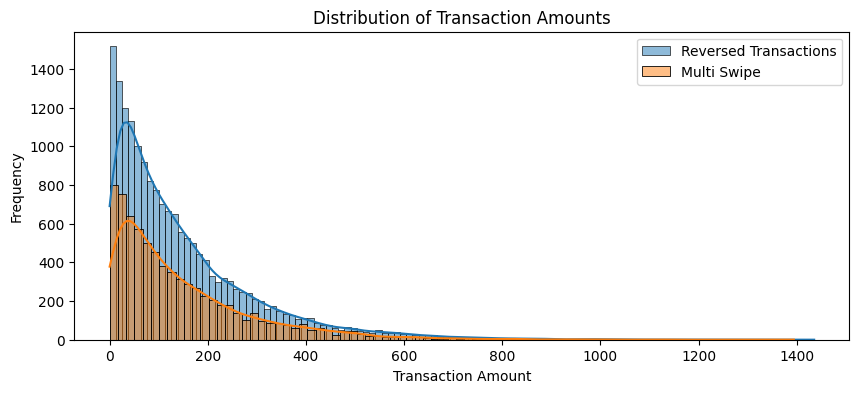

In [28]:
plt.figure(figsize=(10, 4))
sns.histplot(data=reversed_transactions_df, x='transactionAmount', kde=True, label='Reversed Transactions')
sns.histplot(data=multi_swipe, x='transactionAmount', kde=True, label='Multi Swipe')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amounts')
plt.legend()
plt.show()

- Insights: both dataframes show a right-skewed distribution of transaction amounts, suggesting that most transactions are of smaller values. The key difference lies in the frequency of transactions, with the "Reversed Transactions" having a higher frequency compared to the "Multi Swipe Transactions". 

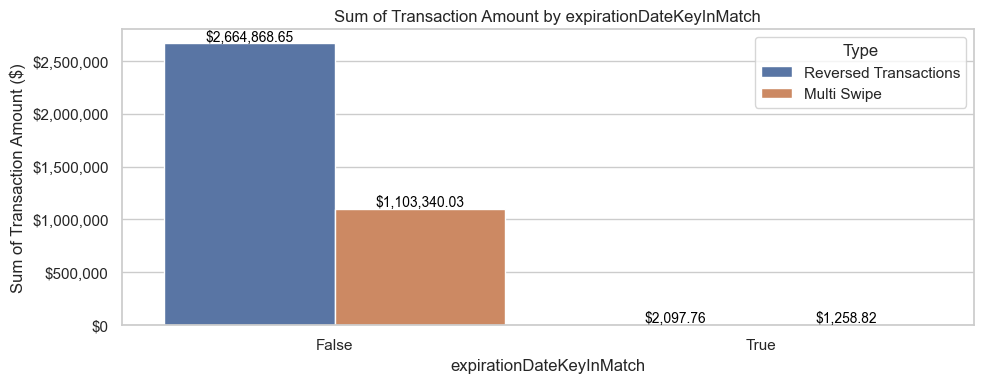

In [52]:
reversed_transactions_sum_by_exp = reversed_transactions_df.groupby('expirationDateKeyInMatch')['transactionAmount'].sum().reset_index()
multi_swipe_sum_by_exp = multi_swipe.groupby('expirationDateKeyInMatch')['transactionAmount'].sum().reset_index()

reversed_transactions_sum_by_exp['Type'] = 'Reversed Transactions'
multi_swipe_sum_by_exp['Type'] = 'Multi Swipe'
combined_df = pd.concat([reversed_transactions_sum_by_exp, multi_swipe_sum_by_exp])
sns.set(style="whitegrid")

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=combined_df, x='expirationDateKeyInMatch', y='transactionAmount', hue='Type')
plt.xlabel('expirationDateKeyInMatch')
plt.ylabel('Sum of Transaction Amount ($)')
plt.title('Sum of Transaction Amount by expirationDateKeyInMatch')
plt.legend(title='Type')

# Format y-axis labels with dollar signs and commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

# Add values on top of bars
for p in ax.patches:
    ax.annotate('${:,.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Dropping the multi-swipe and reversed transactions

To clarify, the purpose of the below code is to identify and remove reversed duplicate transactions from the main dataframe. 

In [28]:
# Merge the dataframes on the common columns
merged_df = df.merge(reversed_transactions_df, on=selected_columns, how="left", indicator=True)

# Identify rows to be removed
rows_to_remove = merged_df["_merge"] == "both"

# Drop the rows from df
df = df[~rows_to_remove]
df.reset_index(drop = True, inplace=True)
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,False,False,False
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,True,False,False
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
4,830329091,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750334,732852505,732852505,50000,48904.96,2016-12-22 18:44:12,119.92,Lyft,US,US,90,...,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1095.04,False,False,False
750335,732852505,732852505,50000,48785.04,2016-12-25 16:20:34,18.89,hulu.com,US,US,09,...,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1214.96,False,False,False
750336,732852505,732852505,50000,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,...,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1233.85,False,False,False
750337,732852505,732852505,50000,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,...,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1283.28,False,False,False


The purpose of the below code is to identify and remove multi swipe duplicate transactions from the main dataframe also considering that few of the entries might got removed while removing reversed transactions.

In [29]:
merged_df_ms = df.merge(multi_swipe, on=df.columns.to_list(), how="left", indicator=True)

# Identify rows to be removed for multi swipe which are present in df
rows_to_remove_ms = merged_df_ms["_merge"] == "both"

# Drop the rows from df
df = df[~rows_to_remove_ms]
df.reset_index(drop = True, inplace=True)
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,False,False,False
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,True,False,False
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,False
4,830329091,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743076,732852505,732852505,50000,48904.96,2016-12-22 18:44:12,119.92,Lyft,US,US,90,...,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1095.04,False,False,False
743077,732852505,732852505,50000,48785.04,2016-12-25 16:20:34,18.89,hulu.com,US,US,09,...,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1214.96,False,False,False
743078,732852505,732852505,50000,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,...,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1233.85,False,False,False
743079,732852505,732852505,50000,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,...,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1283.28,False,False,False


In [30]:
df.shape

(743081, 23)

# Handling Missing Values

In [31]:
missing_columns = df.columns[df.isnull().any()].tolist()

for col in missing_columns:
    value_counts = df[col].value_counts(dropna=False).to_dict()
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda item: item[1], reverse=True))
    
    print(f"Value counts for column '{col}':")
    for value, count in sorted_value_counts.items():
        if pd.isna(value):
            value_str = "NaN"
        else:
            value_str = str(value)
        print(f"  {value_str}: {count}")
    print()

Value counts for column 'acqCountry':
  US: 732086
  NaN: 4307
  MEX: 2964
  CAN: 2262
  PR: 1462

Value counts for column 'merchantCountryCode':
  US: 735675
  MEX: 2972
  CAN: 2266
  PR: 1479
  NaN: 689

Value counts for column 'posEntryMode':
  05: 297935
  09: 223231
  02: 185075
  90: 18554
  80: 14445
  NaN: 3841

Value counts for column 'posConditionCode':
  01: 586595
  08: 139559
  1: 7667
  99: 7043
  8: 1737
  NaN: 384
  99: 96

Value counts for column 'transactionType':
  PURCHASE: 719826
  ADDRESS_VERIFICATION: 20028
  REVERSAL: 2529
  NaN: 698



I'm employing a strategy to leverage the most frequent value within distinct groups, aiming to uncover potential data patterns linked to the fraud status. My approach involves a concise one-liner to carry out this task efficiently. 

Here's how it works: I iterate through each column in the dataframe, and for each column where there are missing values (indicated by df[col].isnull()), I use a grouping mechanism based on the "isFraud" status. Within each "isFraud" group, I replace the missing values with the mode of that group, which is the most common value. This way, I'm effectively filling in the gaps using the prevailing values within each distinct "isFraud" category, helping to reveal any discernible trends or patterns associated with the data's fraud status.

In [32]:
for col in missing_columns:
    df.loc[df[col].isnull(), col] = df.groupby('isFraud')[col].transform(lambda x: x.mode()[0])

In [33]:
df.isna().sum().any()

False

Mode Imputation within Groups (Chosen Method):

- Justification: Preserves group characteristics, avoids data leakage, handles class imbalance, contextually relevant, enhances interpretability.
- Explanation: Imputing missing values with the mode within each 'isFraud' group ensures accurate imputation based on the most common values within each group. This approach is suitable for fraud detection as it maintains the characteristics of each group and avoids data leakage concerns. Class imbalance is handled appropriately, and the imputation aligns with actual patterns in the data. Credit card fraud datasets are typically highly imbalanced, with a small proportion of fraud cases compared to non-fraud cases. By imputing missing values within each 'isFraud' group, ensures that the imputation process isn't skewed by the majority class, potentially leading to more accurate fraud predictions.

# Handling Categorical Variables

In [34]:
categorical_columns = df.select_dtypes(include=['object', 'category','bool']).columns
categorical_columns

Index(['merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode',
       'posConditionCode', 'merchantCategoryCode', 'transactionType',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

In [35]:
pd.set_option('display.max_colwidth', 100)
table_data = []

# First row: nunique() for each column
nunique_row = [df[col].nunique() for col in categorical_columns]
table_data.append(nunique_row)

# Second row: value_counts() for columns with nunique() < 7
value_counts_row = []
for col in categorical_columns:
    if df[col].nunique() < 7:
        value_counts = df[col].value_counts().to_dict()
        value_counts_str = ', '.join([f"{value}: {count}" for value, count in value_counts.items()])
        value_counts_row.append(value_counts_str)
    else:
        value_counts_row.append('')
table_data.append(value_counts_row)

# Create the table
table_df_categorical = pd.DataFrame(table_data, columns=categorical_columns)
table_df_categorical = table_df_categorical.T #transpose
table_df_categorical.columns = ['nunique', 'value_counts']
table_df_categorical


,nunique,value_counts
merchantName,2490,
acqCountry,4,"US: 736393, MEX: 2964, CAN: 2262, PR: 1462"
merchantCountryCode,4,"US: 736364, MEX: 2972, CAN: 2266, PR: 1479"
posEntryMode,5,"05: 301522, 09: 223485, 02: 185075, 90: 18554, 80: 14445"
posConditionCode,6,"01: 586979, 08: 139559, 1: 7667, 99: 7043, 8: 1737, 99: 96"
merchantCategoryCode,19,
transactionType,3,"PURCHASE: 720524, ADDRESS_VERIFICATION: 20028, REVERSAL: 2529"
cardPresent,2,"False: 410380, True: 332701"
expirationDateKeyInMatch,2,"False: 742071, True: 1010"
isFraud,2,"False: 731402, True: 11679"


- I've chosen specific encoding methods for each feature to maximize the interpretability and effectiveness of the data. In this context, I've created an encoding_methods dictionary that outlines my rationale:

- For features like 'acqCountry,' 'merchantCountryCode,' 'transactionType,' 'posEntryMode,' and 'posConditionCode,' I've selected the 'mean' encoding. This decision is based on the assumption that the mean value of the 'isFraud' variable within each category provides a valuable indication of how strongly that category correlates with fraud. This is particularly useful for identifying categories associated with higher or lower rates of fraud.

- Regarding 'cardPresent,' 'expirationDateKeyInMatch,' and 'isFraud,' I've opted for 'binary' encoding. This approach simplifies the boolean information into binary values (0 or 1), making it easier to capture the presence or absence of certain conditions or outcomes.

- For 'merchantName' and 'merchantCategoryCode,' I've chosen 'frequency' encoding. This method captures the relative occurrence of each category in the dataset. By mapping each category to its frequency of appearance, I can assess the significance of these categories based on their representation in the data. While thinking on this I have also seen the value counts for these columns and then based on that finalize my encoding approach.

- In the subsequent loop, I implement these encoding methods. When 'mean' encoding is chosen, I calculate the mean of the 'isFraud' variable within each category and map those values to the respective column. For 'binary' encoding, I use the LabelEncoder to transform categorical values into binary numerical values. For 'frequency' encoding, I map each category to its normalized frequency.

In [42]:
encoding_methods = {
    'acqCountry': 'mean',
    'merchantCountryCode': 'mean',
    'transactionType': 'mean',
    'posEntryMode': 'mean',
    'posConditionCode': 'mean',
    'cardPresent': 'binary',
    'expirationDateKeyInMatch': 'binary',
    'isFraud': 'binary',
    'merchantName': 'frequency',
    'merchantCategoryCode': 'frequency'
}

for col, encoding_method in encoding_methods.items():
    if encoding_method == 'mean':
        mean_encoded_values = df.groupby(col)['isFraud'].mean()
        df[col + '_encoded'] = df[col].map(mean_encoded_values)
    elif encoding_method == 'binary':
        binary_encoder = LabelEncoder()
        df[col + '_encoded'] = binary_encoder.fit_transform(df[col])
    elif encoding_method == 'frequency':
        frequency_encoded_values = df[col].value_counts(normalize=True)
        df[col + '_encoded'] = df[col].map(frequency_encoded_values)


# Drop the original categorical columns
df.drop(list(encoding_methods.keys()), axis=1, inplace=True)

In [37]:
Display_all_columns_nrow(df,8)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,currentBalance,acqCountry_encoded,merchantCountryCode_encoded,transactionType_encoded,posEntryMode_encoded,posConditionCode_encoded,cardPresent_encoded,expirationDateKeyInMatch_encoded,isFraud_encoded,merchantName_encoded,merchantCategoryCode_encoded
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,2023-06-01,2015-03-14,2015-03-14,414,414,1803,0.00,0.015671,0.01567,0.016001,0.017523,0.016278,0,0,0,0.032477,0.064877
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,2024-02-01,2015-03-14,2015-03-14,486,486,767,0.00,0.015671,0.01567,0.016001,0.024892,0.016278,1,0,0,0.004841,0.101406
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,2025-08-01,2015-03-14,2015-03-14,486,486,767,0.00,0.015671,0.01567,0.016001,0.024892,0.016278,0,0,0,0.009984,0.020173
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,2025-08-01,2015-03-14,2015-03-14,486,486,767,0.00,0.015671,0.01567,0.016001,0.024892,0.016278,0,0,0,0.009984,0.020173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743077,732852505,732852505,50000,48785.04,2016-12-25 16:20:34,18.89,2023-08-01,2012-08-23,2012-08-23,939,939,3388,1214.96,0.015671,0.01567,0.016001,0.024892,0.016278,0,0,0,0.003578,0.014893
743078,732852505,732852505,50000,48766.15,2016-12-27 15:46:24,49.43,2025-08-01,2012-08-23,2012-08-23,936,936,3783,1233.85,0.015671,0.01567,0.016001,0.017523,0.016278,0,0,0,0.032400,0.064877
743079,732852505,732852505,50000,48716.72,2016-12-29 00:30:55,49.89,2022-07-01,2012-08-23,2012-08-23,939,939,3388,1283.28,0.015671,0.01567,0.016001,0.024892,0.029959,0,0,0,0.021481,0.256066
743080,732852505,732852505,50000,48666.83,2016-12-30 20:10:29,72.18,2024-05-01,2012-08-23,2012-08-23,939,939,3388,1333.17,0.015671,0.01567,0.016001,0.007658,0.016278,0,0,0,0.032477,0.064877


In [38]:
df_copy = df.copy()

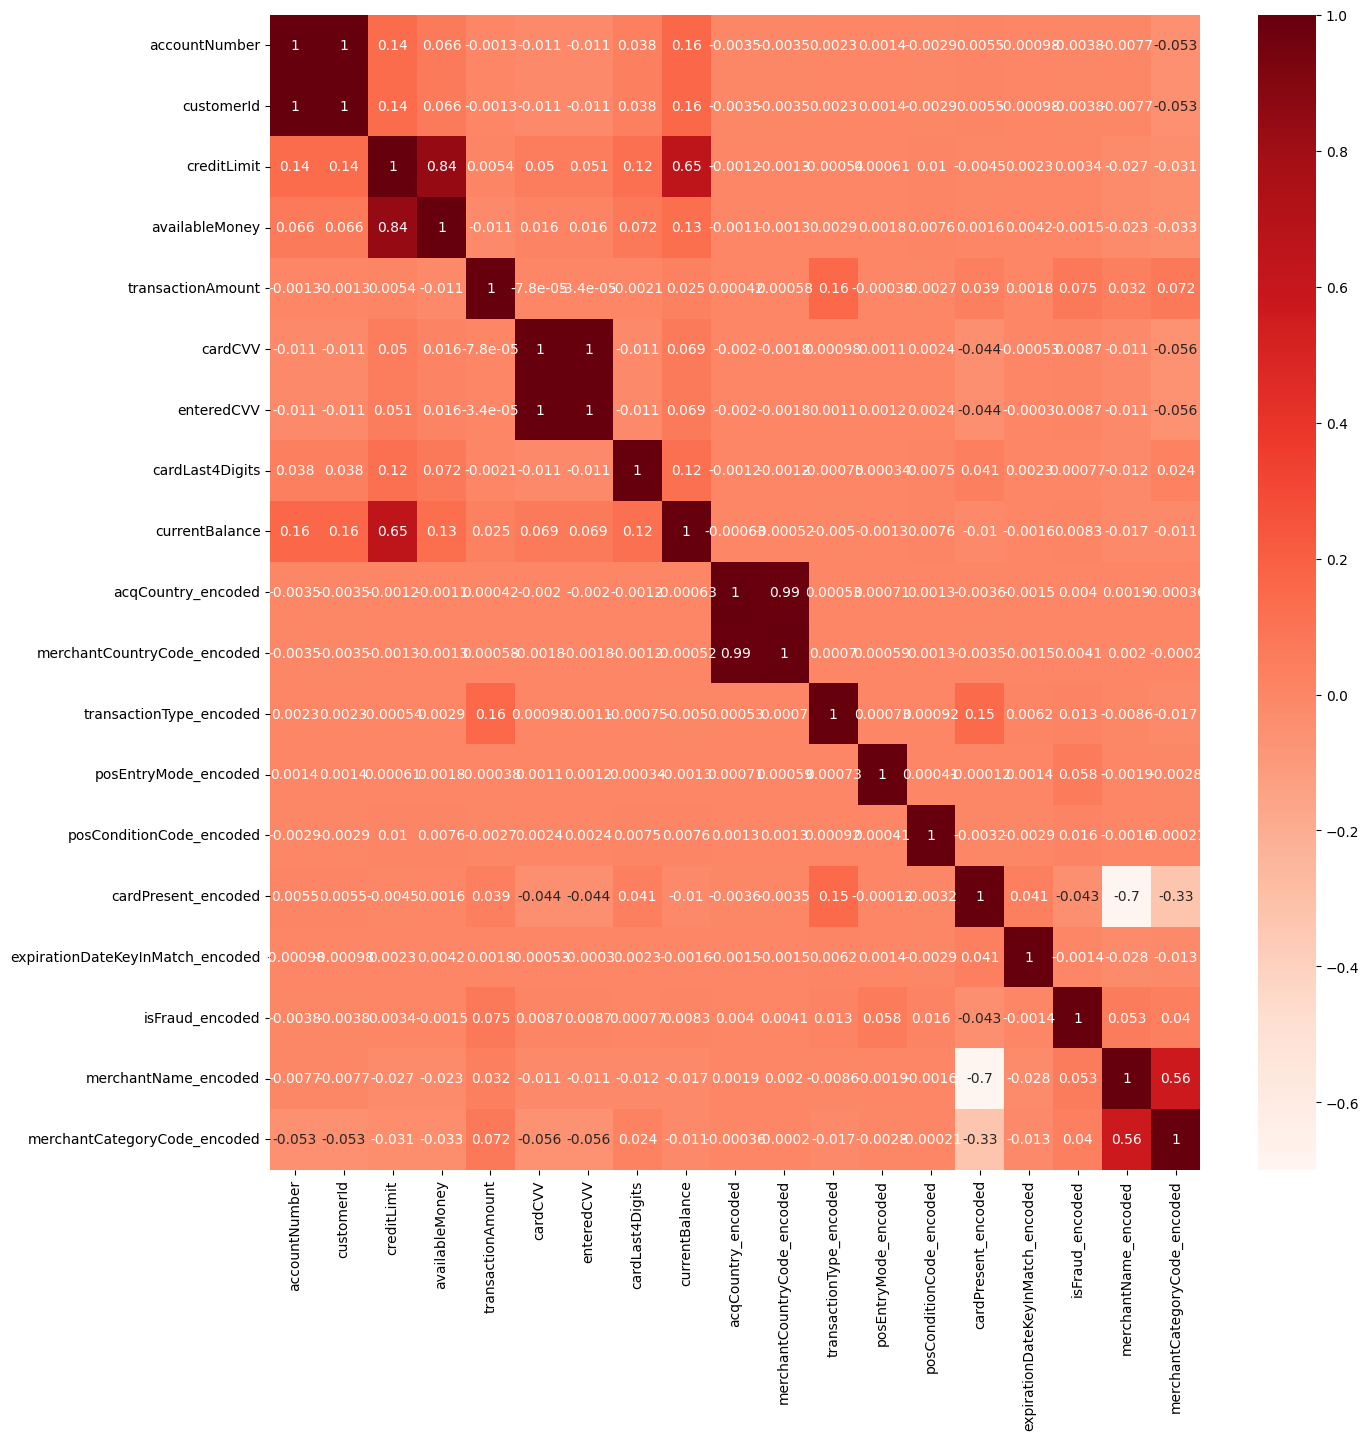

In [44]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    plt.figure(figsize=(15,15))
    sns.heatmap(df.corr(),annot=True,cmap=plt.cm.Reds)

In [52]:
# Deriving Attributes
df['CVV_matched'] = (df['cardCVV'] == df['enteredCVV']).astype(int)

I am opting not to extract additional features such as year, month, day, or day of the week from the datetime columns. These extractions would indeed increase the dimensionality of the data, potentially leading to challenges in model complexity. Instead, I intend to apply the Min-Max scaling technique directly to the datetime columns. This approach preserves the original column while normalizing the values within a consistent range, aiding in model convergence and performance.

- Dropping Identifiers Columns: I have decided to drop the 'accountNumber' and 'customerId' columns. These identifiers are not essential for the modeling process and do not contribute to detecting fraudulent transactions.

- Dropping Irrelevant Columns: I have removed the 'dateOfLastAddressChange' column, as it is not directly relevant to identifying fraudulent transactions. Our focus is on transaction-related features.

- Deriving Available Money: I have dropped the 'availableMoney' column. This column can be derived from the 'creditLimit' and 'currentBalance' columns, and having it as a separate feature is redundant. The available money can be calculated as the difference between the credit limit and the current balance.

- Creating CVV Match Indicator: I have introduced a new column called 'CVV_matched', which takes binary values (0 or 1). This column indicates whether the entered CVV matches the card's CVV. After introducing this feature, I have dropped the 'cardCVV' and 'enteredCVV' columns, as they are no longer needed.

In [50]:
df = df.drop(['accountNumber', 'customerId', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionDateTime', 'currentExpDate', 
                'accountOpenDate', 'dateOfLastAddressChange', 'availableMoney'], axis=1)


# Normalization

In [48]:
minmaxscaler = MinMaxScaler()
datetime_columns = ['transactionDateTime', 'currentExpDate', 'accountOpenDate']

for col in datetime_columns:
    col_data = df[col].values.reshape(-1, 1)  # Reshape to a 2D array
    df[col] = minmaxscaler.fit_transform(col_data)

In [54]:
df.describe()

,creditLimit,transactionAmount,currentBalance,acqCountry_encoded,merchantCountryCode_encoded,transactionType_encoded,posEntryMode_encoded,posConditionCode_encoded,cardPresent_encoded,expirationDateKeyInMatch_encoded,isFraud_encoded,merchantName_encoded,merchantCategoryCode_encoded,CVV_matched
count,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000
mean,10753.497936,136.285571,4494.016106,0.015717,0.015717,0.015717,0.015717,0.015717,0.447732,0.001359,0.015717,0.009522,0.123092,0.991064
std,11630.116861,147.537715,6450.323060,0.000497,0.000508,0.001659,0.007263,0.001990,0.497261,0.036842,0.124378,0.010417,0.086415,0.094106
min,250.000000,0.000000,0.000000,0.015671,0.015670,0.005792,0.007658,0.000000,0.000000,0.000000,0.000000,0.000001,0.001860,0.000000
25%,5000.000000,33.260000,680.130000,0.015671,0.015670,0.016001,0.007658,0.016278,0.000000,0.000000,0.000000,0.000346,0.043040,1.000000
50%,7500.000000,87.020000,2434.700000,0.015671,0.015670,0.016001,0.017523,0.016278,0.000000,0.000000,0.000000,0.004792,0.095514,1.000000
75%,15000.000000,190.580000,5267.430000,0.015671,0.015670,0.016001,0.024892,0.016278,1.000000,0.000000,0.000000,0.021260,0.256066,1.000000
max,50000.000000,2011.540000,47498.810000,0.021662,0.022065,0.016001,0.024892,0.029959,1.000000,1.000000,1.000000,0.032477,0.256066,1.000000


In [57]:
columns_to_normalize = ['creditLimit', 'transactionAmount', 'currentBalance']

# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()
for col in columns_to_normalize:
    col_data = df[col].values.reshape(-1, 1)
    df[col] = minmax_scaler.fit_transform(col_data) 

In [58]:
df.describe()

,creditLimit,transactionAmount,currentBalance,acqCountry_encoded,merchantCountryCode_encoded,transactionType_encoded,posEntryMode_encoded,posConditionCode_encoded,cardPresent_encoded,expirationDateKeyInMatch_encoded,isFraud_encoded,merchantName_encoded,merchantCategoryCode_encoded,CVV_matched
count,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000
mean,0.211126,0.067752,0.094613,0.015717,0.015717,0.015717,0.015717,0.015717,0.447732,0.001359,0.015717,0.009522,0.123092,0.991064
std,0.233771,0.073346,0.135800,0.000497,0.000508,0.001659,0.007263,0.001990,0.497261,0.036842,0.124378,0.010417,0.086415,0.094106
min,0.000000,0.000000,0.000000,0.015671,0.015670,0.005792,0.007658,0.000000,0.000000,0.000000,0.000000,0.000001,0.001860,0.000000
25%,0.095477,0.016535,0.014319,0.015671,0.015670,0.016001,0.007658,0.016278,0.000000,0.000000,0.000000,0.000346,0.043040,1.000000
50%,0.145729,0.043260,0.051258,0.015671,0.015670,0.016001,0.017523,0.016278,0.000000,0.000000,0.000000,0.004792,0.095514,1.000000
75%,0.296482,0.094743,0.110896,0.015671,0.015670,0.016001,0.024892,0.016278,1.000000,0.000000,0.000000,0.021260,0.256066,1.000000
max,1.000000,1.000000,1.000000,0.021662,0.022065,0.016001,0.024892,0.029959,1.000000,1.000000,1.000000,0.032477,0.256066,1.000000


In [60]:
# Normalizing some of the mean encoded column to increase the scale to O-1
columns_to_normalize = ['transactionType_encoded', 'posEntryMode_encoded', 'posConditionCode_encoded']
scaler = MinMaxScaler()
for col in columns_to_normalize:
    col_data = df[col].values.reshape(-1, 1)
    df[col] = scaler.fit_transform(col_data)
df.describe()

,creditLimit,transactionAmount,currentBalance,acqCountry_encoded,merchantCountryCode_encoded,transactionType_encoded,posEntryMode_encoded,posConditionCode_encoded,cardPresent_encoded,expirationDateKeyInMatch_encoded,isFraud_encoded,merchantName_encoded,merchantCategoryCode_encoded,CVV_matched
count,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000,743081.000000
mean,0.211126,0.067752,0.094613,0.015717,0.015717,0.972195,0.467626,0.524620,0.447732,0.001359,0.015717,0.009522,0.123092,0.991064
std,0.233771,0.073346,0.135800,0.000497,0.000508,0.162459,0.421417,0.066428,0.497261,0.036842,0.124378,0.010417,0.086415,0.094106
min,0.000000,0.000000,0.000000,0.015671,0.015670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.001860,0.000000
25%,0.095477,0.016535,0.014319,0.015671,0.015670,1.000000,0.000000,0.543355,0.000000,0.000000,0.000000,0.000346,0.043040,1.000000
50%,0.145729,0.043260,0.051258,0.015671,0.015670,1.000000,0.572396,0.543355,0.000000,0.000000,0.000000,0.004792,0.095514,1.000000
75%,0.296482,0.094743,0.110896,0.015671,0.015670,1.000000,1.000000,0.543355,1.000000,0.000000,0.000000,0.021260,0.256066,1.000000
max,1.000000,1.000000,1.000000,0.021662,0.022065,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.032477,0.256066,1.000000


In [86]:
df.isFraud_encoded.value_counts()

0    731402
1     11679
Name: isFraud_encoded, dtype: int64

# Under Sampling for one Iteration and basic Modeling

In [89]:
def under_sampling(df, n_sample):
    # Get indices of class 0 samples
    indices_class_0 = df[df['isFraud_encoded'] == 0].index
    # Randomly sample indices from class 0 to match the size of class 1
    sampled_indices_class_0 = pd.Index(pd.Series(indices_class_0).sample(n=n_sample))
    
    # Combine the sampled indices of class 0 with indices of class 1
    balanced_indices = sampled_indices_class_0.append(df[df['isFraud_encoded'] == 1].index)
    balanced_df = df.loc[balanced_indices]
    return balanced_df

In [95]:
balanced_df = under_sampling(df, 11679)
b_X = balanced_df.drop('isFraud_encoded', axis=1)
b_y = balanced_df['isFraud_encoded']
X_train, X_test, y_train, y_test = train_test_split(b_X, b_y, test_size=0.2, stratify=b_y, random_state=42)

In [98]:
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

   Not Fraud       0.70      0.68      0.69      2336
       Fraud       0.69      0.71      0.70      2336

    accuracy                           0.69      4672
   macro avg       0.69      0.69      0.69      4672
weighted avg       0.69      0.69      0.69      4672

Accuracy: 0.6919948630136986


In [99]:
rf = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, rf.predict(X_test), target_names=['Not Fraud', 'Fraud']))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

   Not Fraud       0.69      0.61      0.64      2336
       Fraud       0.65      0.72      0.68      2336

    accuracy                           0.67      4672
   macro avg       0.67      0.67      0.66      4672
weighted avg       0.67      0.67      0.66      4672

Accuracy: 0.6654537671232876


In [100]:
svc = LinearSVC(class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, svc.predict(X_test), target_names=['Not Fraud', 'Fraud']))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

   Not Fraud       0.67      0.69      0.68      2336
       Fraud       0.68      0.66      0.67      2336

    accuracy                           0.67      4672
   macro avg       0.67      0.67      0.67      4672
weighted avg       0.67      0.67      0.67      4672

Accuracy: 0.6740154109589042


In [107]:
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X_train)
y_pred = clf.predict(X_test)
y_pred_binary = [1 if pred == 1 else 0 for pred in y_pred]
auc_score = roc_auc_score(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)
print("AUC:", auc_score)
print("Classification Report:\n", class_report)


C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


AUC: 0.501498287671233
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.11      0.18      2336
           1       0.50      0.89      0.64      2336

    accuracy                           0.50      4672
   macro avg       0.50      0.50      0.41      4672
weighted avg       0.50      0.50      0.41      4672



# Modeling, and Under Sampling for n-Iterations with Hyper Parameter Tuning

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

def under_sampling_and_model(df, model_type, n_sample, n_iterations=10):
    avg_accuracy = 0
    avg_fraud_precision = 0
    avg_fraud_recall = 0
    avg_fraud_f1 = 0
    avg_auc = 0
    f1_values = []
    best_models = []

    for i in range(n_iterations):
        balanced_df = under_sampling(df, n_sample)
        b_X = balanced_df.drop('isFraud_encoded', axis=1)
        b_y = balanced_df['isFraud_encoded']
        X_train, X_test, y_train, y_test = train_test_split(b_X, b_y, test_size=0.2, stratify=b_y)

        if model_type == "RandomForest":
            model = RandomForestClassifier()
            param_grid = {
                'max_depth' : list(range(2, 10)),
                'criterion' : ["gini", "entropy"],
                'n_estimators' : list(range(20, 200, 30))
            }
        elif model_type == "GradientBoosting":
            model = GradientBoostingClassifier()
            param_grid = {
                'n_estimators': list(range(60, 220, 40)),
                'learning_rate': [0.1, 0.01, 0.05],
                'max_depth': list(range(2, 10))
            }
        elif model_type == "XGBoost":
            model = xgb.XGBClassifier()
            param_grid = {
                'max_depth': list(range(2, 10)),
                'learning_rate': [0.1, 0.01, 0.05],
                'n_estimators': list(range(60, 220, 40)),
                'reg_lambda' : [i/10 for i in range(10, 51)],
                'reg_alpha' : [i/10 for i in range(0, 51)],
                'gamma' : list(range(0, 11, 5)),
                'colsample_bytree' : [i/10 for i in range(6, 10)]
            }


        if model_type == "XGBoost":
            method_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1', n_iter=15)
            method_search.fit(X_train, y_train)
        else:
            method_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
            method_search.fit(X_train, y_train)

        best_model = method_search.best_estimator_
        best_models.append(best_model)

        y_pred = best_model.predict(X_test)

        avg_auc += roc_auc_score(y_test, y_pred)
        avg_accuracy += accuracy_score(y_test, y_pred)
        class_rep = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'], output_dict=True)
        avg_fraud_precision += class_rep['Fraud']['precision']
        avg_fraud_recall += class_rep['Fraud']['recall']
        avg_fraud_f1 += class_rep['Fraud']['f1-score']
        f1_values.append(round(class_rep['Fraud']['f1-score'],4))
        # print(f'{i} Iteration completed for a Model')

    avg_auc /= n_iterations
    avg_accuracy /= n_iterations
    avg_fraud_precision /= n_iterations
    avg_fraud_recall /= n_iterations
    avg_fraud_f1 /= n_iterations
    
    print(f"Model Type: {model_type}")
    print(f"Average Accuracy for {n_iterations} times undersampling: {round(avg_accuracy,4)}")
    print(f"Average Fraud Precision for {n_iterations} times undersampling: {round(avg_fraud_precision,4)}")
    print(f"Average Fraud Recall for {n_iterations} times undersampling: {round(avg_fraud_recall,4)}")
    print(f"Average AUC Score for {n_iterations} times undersampling: {round(avg_auc,4)}")
    print(f"Average Fraud F1-score for {n_iterations} times undersampling: {round(avg_fraud_f1,4)}")
    print(f"F1 Score list for {n_iterations}: {f1_values}")
    print(f"Max F1 Score list for {n_iterations}: {max(f1_values)}\n")

    return best_models

# Call the function for each model type and store best models
n_sample = df.isFraud_encoded.value_counts()[1]
rf_model = under_sampling_and_model(df, "RandomForest", n_sample)
gb_model = under_sampling_and_model(df, "GradientBoosting", n_sample)
xgb_model = under_sampling_and_model(df, "XGBoost", n_sample)


Model Type: RandomForest
Average Accuracy for 10 times undersampling: 0.7034
Average Fraud Precision for 10 times undersampling: 0.7067
Average Fraud Recall for 10 times undersampling: 0.6959
Average AUC Score for 10 times undersampling: 0.7034
Average Fraud F1-score for 10 times undersampling: 0.7012
F1 Score list for 10: [0.7049, 0.7061, 0.706, 0.6988, 0.7012, 0.6935, 0.7018, 0.701, 0.6981, 0.7005]
Max F1 Score list for 10: 0.7061

Model Type: GradientBoosting
Average Accuracy for 10 times undersampling: 0.7108
Average Fraud Precision for 10 times undersampling: 0.7138
Average Fraud Recall for 10 times undersampling: 0.7037
Average AUC Score for 10 times undersampling: 0.7108
Average Fraud F1-score for 10 times undersampling: 0.7087
F1 Score list for 10: [0.7194, 0.7067, 0.7078, 0.7081, 0.6943, 0.7131, 0.7137, 0.7047, 0.7116, 0.7077]
Max F1 Score list for 10: 0.7194

Model Type: XGBoost
Average Accuracy for 10 times undersampling: 0.7117
Average Fraud Precision for 10 times undersamp

In [118]:
allmodels = [rf_model,gb_model,xgb_model]
for models in allmodels: 
    display(models)

[RandomForestClassifier(max_depth=9, n_estimators=80),
 RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=170),
 RandomForestClassifier(max_depth=9, n_estimators=140),
 RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=80),
 RandomForestClassifier(max_depth=9, n_estimators=140),
 RandomForestClassifier(max_depth=9, n_estimators=170),
 RandomForestClassifier(max_depth=9, n_estimators=110),
 RandomForestClassifier(max_depth=9, n_estimators=50),
 RandomForestClassifier(max_depth=9, n_estimators=80),
 RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=170)]

[GradientBoostingClassifier(max_depth=7, n_estimators=180),
 GradientBoostingClassifier(learning_rate=0.05, max_depth=8, n_estimators=180),
 GradientBoostingClassifier(max_depth=7),
 GradientBoostingClassifier(max_depth=6, n_estimators=180),
 GradientBoostingClassifier(max_depth=5, n_estimators=180),
 GradientBoostingClassifier(max_depth=6, n_estimators=140),
 GradientBoostingClassifier(max_depth=6, n_estimators=180),
 GradientBoostingClassifier(max_depth=7),
 GradientBoostingClassifier(max_depth=6, n_estimators=180),
 GradientBoostingClassifier(learning_rate=0.05, max_depth=7, n_estimators=180)]

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=140, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.6, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=N

In [130]:
allmodels = [rf_model,gb_model,xgb_model]
# Second model is performing well for Random Forest
best_rf_model = rf_model[0]
display(best_rf_model)
# First model is [erforming best in Gradient Boosting
best_gb_model = gb_model[0]
display(best_gb_model)
# Last model is performing best in XGBoost
best_xgb_model = xgb_model[9]
display(best_xgb_model)

RandomForestClassifier(max_depth=9, n_estimators=80)

GradientBoostingClassifier(max_depth=7, n_estimators=180)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [53]:
# Create the folder if it doesn't exist
if not os.path.exists("best_models"):
    os.makedirs("best_models")

# Save the best models
joblib.dump(best_rf_model, "best_models/best_rf_model.pkl")
joblib.dump(best_gb_model, "best_models/best_gb_model.pkl")
joblib.dump(best_xgb_model, "best_models/best_xgb_model.pkl")

In [147]:
def evaluate_model(model, X_test, y_test):   
    y_pred = model.predict(X_test) # Make predictions
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:")
    print(conf_matrix)  
    # Plot PR Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(6, 4))
    plt.plot(recall_curve, precision_curve, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Random Forest best Model Evaluation Metrics:
Accuracy: 0.7193921232876712
Precision: 0.7189235369500213
Recall: 0.7204623287671232
F1-Score: 0.7196921103271328
Confusion Matrix:
[[1678  658]
 [ 653 1683]]


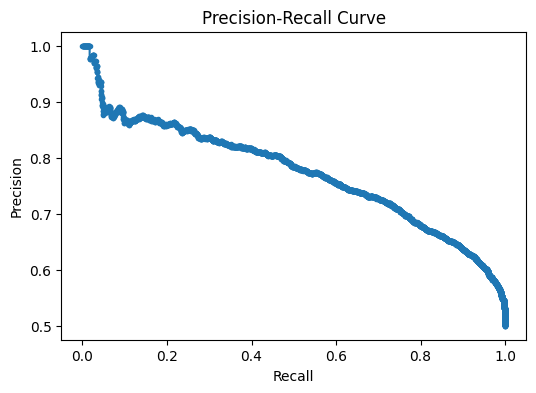

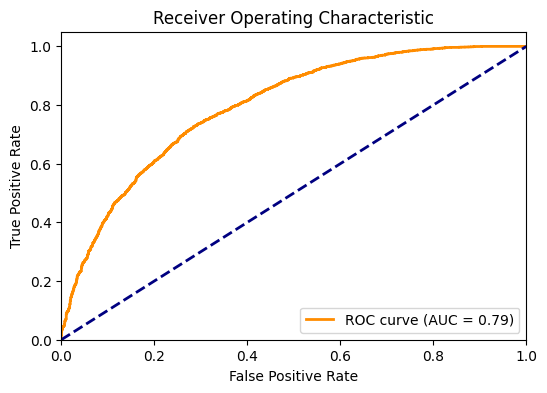

In [153]:
print("Random Forest best Model Evaluation Metrics:")
evaluate_model(best_rf_model, X_test, y_test)

Gradient Boosting Classifier best Model Evaluation Metrics:
Accuracy: 0.7686215753424658
Precision: 0.738321306494493
Recall: 0.8321917808219178
F1-Score: 0.782451197424029
Confusion Matrix:
[[1647  689]
 [ 392 1944]]


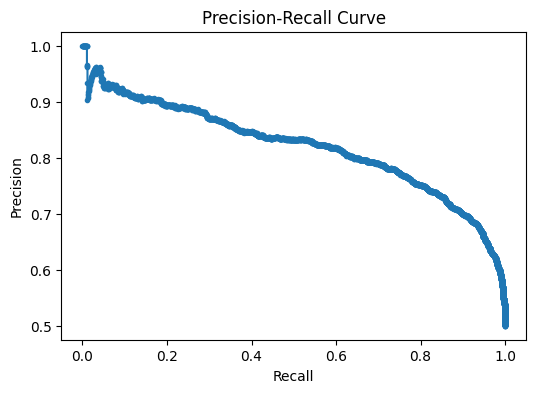

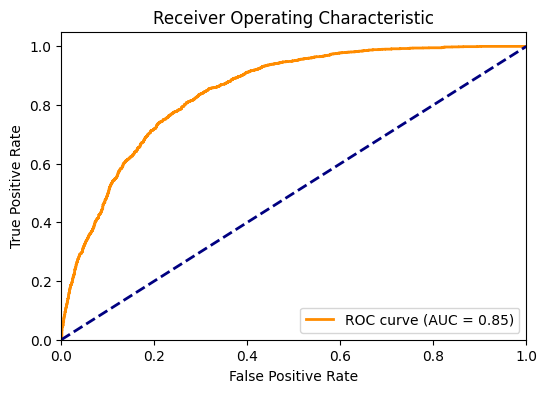

In [152]:
print("Gradient Boosting Classifier best Model Evaluation Metrics:")
evaluate_model(best_gb_model, X_test, y_test)

XGBoost best Model Evaluation Metrics:
Accuracy: 0.7219606164383562
Precision: 0.7216759298845661
Recall: 0.7226027397260274
F1-Score: 0.7221390374331551
Confusion Matrix:
[[1685  651]
 [ 648 1688]]


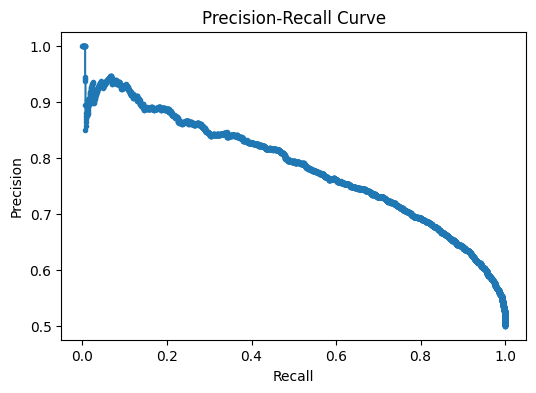

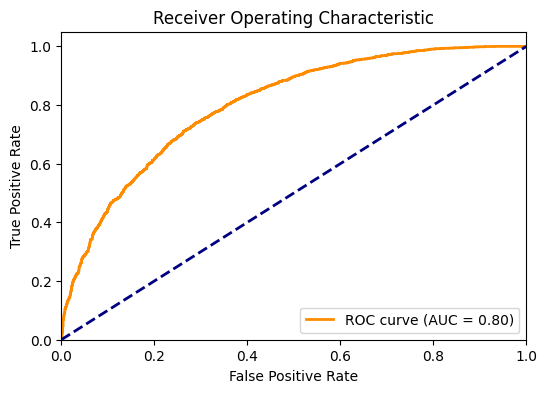

In [155]:
print("XGBoost best Model Evaluation Metrics:")
evaluate_model(best_xgb_model, X_test, y_test)

- Among the three models evaluated for credit fraud detection, the Gradient Boosting Classifier stands out as the most promising choice. It achieves the highest levels of Recall (0.832), which is crucial in detecting fraudulent transactions. The model's higher recall indicates its ability to capture a substantial portion of actual fraud cases. Additionally, the model maintains a strong Precision (0.738) and a balanced F1-Score (0.782), showcasing an effective trade-off between precision and recall. Furthermore, the Area Under the Curve (AUC) value of 0.850 indicates solid discrimination power, confirming its effectiveness in distinguishing between positive and negative cases.

- Considering the primary goal of credit fraud detection, where identifying actual fraud cases is paramount, the Gradient Boosting Classifier's superior recall and balanced performance make it the recommended choice.

With additional time devoted to tackling this challenge, I would consider implementing a more comprehensive and data-driven approach to enhance the credit fraud detection model. Here's an improved strategy:

- Clustering for Data Segmentation: Apply clustering algorithms (e.g., K-Means, DBSCAN) to segment the data into meaningful clusters.
Use cluster labels as an additional feature for modeling.

- Iterative Undersampling: For each cluster, perform iterative undersampling to balance the class distribution.
Undersample the majority class while maintaining diversity within the dataset.

- Model Selection and Tuning: For each cluster, explore a variety of classification models (e.g., Random Forest, Gradient Boosting, XGBoost, Support Vector Machines) with hyperparameter tuning.
Utilize techniques like cross-validation to find the best model configuration for each cluster.

- Testing and Ensemble: For a given test transaction, determine its cluster using the clustering model.
Apply the best-performing model from that cluster for fraud classification.

- Ensemble Strategies: Explore ensemble techniques (e.g., stacking) to combine predictions from different models.
Weight the predictions based on the performance of each model and the cluster it's associated with.

- Model Evaluation and Monitoring: Regularly evaluate models on validation and holdout sets to ensure generalization to unseen data. Implement monitoring mechanisms to detect model degradation or concept drift.

- Feature Engineering: Experiment with feature engineering techniques, such as creating time-based features, transaction frequency, and transaction value ratios.

Continuous Learning: Continuously update and refine the model as new data becomes available.
Keep exploring new techniques and research in fraud detection.
